## Forecasting: multivariate, hierarchical, and heavy tailed

This tutorial introduces the [pyro.contrib.forecast](http://docs.pyro.ai/en/latest/contrib.forecast.html) module, a framework for forecasting with Pyro models.

In [1]:
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, backtest
from pyro.ops.tensor_utils import periodic_cumsum, periodic_repeat
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.rc = {'figure.facecolor': (1, 1, 1, 1)}
%config InlineBackend.figure_formats = ['svg']
assert pyro.__version__.startswith('1.2.1')
pyro.enable_validation(True)
pyro.set_rng_seed(20200221)

In [2]:
dataset = load_bart_od()
print(" ".join(dataset["stations"]))

12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


The full dataset has all station->station ridership counts for all of 50 train stations. In this simple example we will model only the aggretate counts to and from a single station, Embarcadero.

In [3]:
i = dataset["stations"].index("EMBR")
arrivals = dataset["counts"][:, :, i].sum(-1)
departures = dataset["counts"][:, i, :].sum(-1)
data = torch.stack([arrivals, departures], dim=-1).log1p()
covariates = torch.zeros(len(data), 0)

## A simple bivariate model

In [4]:
class Model(ForecastingModel):
    def model(self, zero_data, covariates):
        period = 24 * 7
        duration, dim = zero_data.shape[-2:]
        assert dim == 2  # Data is bivariate: (arrivals, departures).

        # Sample global parameters.
        noise_scale = pyro.sample("noise_scale",
                                  dist.LogNormal(torch.full((dim,), -3), 1).to_event(1))
        assert noise_scale.shape[-1:] == (dim,)
        trans_timescale = pyro.sample("trans_timescale",
                                      dist.LogNormal(torch.zeros(dim), 1).to_event(1))
        assert trans_timescale.shape[-1:] == (dim,)

        trans_loc = pyro.sample("trans_loc", dist.Cauchy(0, 1 / period))
        trans_loc = trans_loc.unsqueeze(-1).expand(trans_loc.shape + (dim,))
        assert trans_loc.shape[-1:] == (dim,)

        trans_scale = pyro.sample("trans_scale",
                                  dist.LogNormal(torch.zeros(dim), 0.1).to_event(1))
        trans_corr = pyro.sample("trans_corr",
                                 dist.LKJCorrCholesky(dim, torch.ones(())))
        trans_scale_tril = trans_scale.unsqueeze(-1) * trans_corr
        assert trans_scale_tril.shape[-2:] == (dim, dim)

        obs_scale = pyro.sample("obs_scale",
                                dist.LogNormal(torch.zeros(dim), 0.1).to_event(1))
        obs_corr = pyro.sample("obs_corr",
                               dist.LKJCorrCholesky(dim, torch.ones(())))
        obs_scale_tril = obs_scale.unsqueeze(-1) * obs_corr
        assert obs_scale_tril.shape[-2:] == (dim, dim)

        with pyro.plate("season_plate", period,  dim=-1):
            season_init = pyro.sample("season_init",
                                      dist.Normal(torch.zeros(dim), 1).to_event(1))
            assert season_init.shape[-2:] == (period, dim)

        # Sample independent noise at each time step.
        with self.time_plate:
            season_noise = pyro.sample("season_noise",
                                       dist.Normal(0, noise_scale).to_event(1))
            assert season_noise.shape[-2:] == (duration, dim)

        prediction = (periodic_repeat(season_init, duration, dim=-2) +
                      periodic_cumsum(season_noise, period, dim=-2))
        assert prediction.shape[-2:] == (duration, dim)

        init_dist = dist.Normal(torch.zeros(dim), 100).to_event(1)
        trans_mat = trans_timescale.neg().exp().diag_embed()
        trans_dist = dist.MultivariateNormal(trans_loc, scale_tril=trans_scale_tril)
        obs_mat = torch.eye(dim)
        obs_dist = dist.MultivariateNormal(torch.zeros(dim), scale_tril=obs_scale_tril)
        noise_model = dist.GaussianHMM(init_dist, trans_mat, trans_dist, obs_mat, obs_dist,
                                       duration=duration)
        assert noise_model.event_shape == (duration, dim)

        self.predict(noise_model, prediction)

In [5]:
pyro.clear_param_store()

t_train = 90 * 24
forecaster = Forecaster(Model(), data[:t_train], covariates[:t_train],
                        learning_rate=0.05,
                        num_steps=501,
                        log_every=50)

INFO 	 step    0 loss = 10.5934
INFO 	 step   50 loss = 2.00916
INFO 	 step  100 loss = 1.6329
INFO 	 step  150 loss = 1.53326
INFO 	 step  200 loss = 1.49898
INFO 	 step  250 loss = 1.35078
INFO 	 step  300 loss = 1.30465
INFO 	 step  350 loss = 1.31675
INFO 	 step  400 loss = 1.27292
INFO 	 step  450 loss = 1.23511
INFO 	 step  500 loss = 1.17059


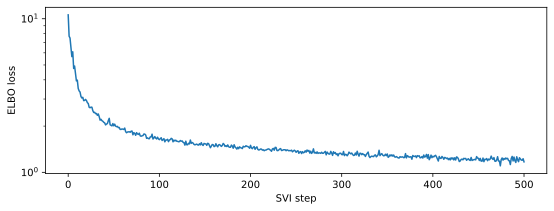

In [6]:
plt.figure(figsize=(9, 3))
plt.plot(forecaster.losses)
plt.ylabel("ELBO loss")
plt.xlabel("SVI step")
plt.yscale("log")

In [7]:
t_test = 2 * 7 * 24
samples = forecaster(data[:t_train], covariates[:t_train + t_test], num_samples=101)
samples.clamp_(min=0);
p05 = samples.kthvalue(5, dim=0).values
p50 = samples.median(dim=0).values
p95 = samples.kthvalue(95, dim=0).values

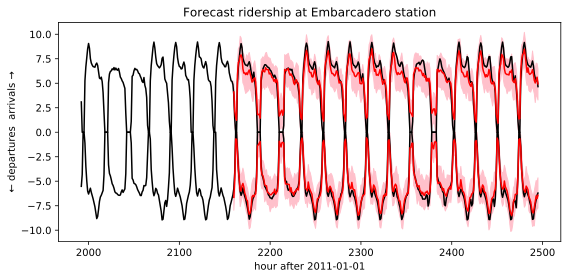

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(torch.arange(t_train - t_test // 2, t_train + t_test),
         data[t_train - t_test // 2:t_train + t_test, 0], "k-")
plt.plot(torch.arange(t_train - t_test // 2, t_train + t_test),
         -data[t_train - t_test // 2:t_train + t_test, 1], "k-")
plt.fill_between(torch.arange(t_train, t_train + t_test), p05[..., 0], p95[..., 0],
                 color="pink")
plt.fill_between(torch.arange(t_train, t_train + t_test), -p05[..., 1], -p95[..., 1],
                 color="pink")
plt.plot(torch.arange(t_train, t_train + t_test), p50[..., 0], "r-")
plt.plot(torch.arange(t_train, t_train + t_test), -p50[..., 1], "r-")
plt.ylabel("← departures  arrivals →")
plt.xlabel("hour after 2011-01-01")
plt.title("Forecast ridership at Embarcadero station")
plt.tight_layout()